# Pipelines

EvalML pipelines represent a sequence of operations to be applied to data, where each operation is either a data transformation or an ML modeling algorithm.

A pipeline class holds a combination of one or more components, which will be applied to new input data in sequence.

Each component and pipeline class supports a set of parameters which configure its behavior. The AutoML search process seeks to find the combination of pipeline structure and pipeline parameters which perform the best on the data.

## Class Definition
Pipeline definitions must inherit from the proper pipeline base class, `RegressionPipeline`, `BinaryClassificationPipeline` or `MulticlassClassificationPipeline`. They must also include a `component_graph` list as a class variable containing the sequence of components to be fit and evaluated. The `component_graph` list is used to determine the ordered list of components that should be instantiated when a pipeline instance is created. Each component in `component_graph` can be provided as a reference to the component class for custom components, and as either a string name or as a reference to the component class for components defined in EvalML.

In [1]:
from evalml.pipelines import MulticlassClassificationPipeline

class CustomMulticlassClassificationPipeline(MulticlassClassificationPipeline):
    component_graph = ['Imputer', 'Random Forest Classifier']

2020-11-24 23:07:12,116 featuretools - WARNING    Featuretools failed to load plugin nlp_primitives from library nlp_primitives. For a full stack trace, set logging to debug.


If you're using your own [custom components](components.ipynb) you can refer to them like so:

In [2]:
from evalml.pipelines.components import Transformer

class NewTransformer(Transformer):
    name = 'New Transformer'
    hyperparameter_ranges = {
        "parameter_1":['a', 'b', 'c']
    }
    
    def __init__(self, parameter_1, random_state):
        transformer = ThirdPartyTransformer(parameter_1)
        parameters = {"parameter_1": parameter_1}
        super().__init__(parameters=parameters,
                         component_obj=transformer,
                         random_state=random_state)
    
class CustomComponentMulticlassClassificationPipeline(MulticlassClassificationPipeline):
    component_graph = [NewTransformer, 'Random Forest Classifier']

## Pipeline Usage

All pipelines define the following methods:

* `fit` fits each component on the provided training data, in order.

* `predict` computes the predictions of the component graph on the provided data.

* `score` computes the value of [an objective](objectives.ipynb) on the provided data.

In [3]:
from evalml.demos import load_wine
X, y = load_wine()

pipeline = CustomMulticlassClassificationPipeline({})
pipeline.fit(X, y)
print(pipeline.predict(X))
print(pipeline.score(X, y, objectives=['log loss multiclass']))

0      class_0
1      class_0
2      class_0
3      class_0
4      class_0
        ...   
173    class_2
174    class_2
175    class_2
176    class_2
177    class_2
Length: 178, dtype: object
OrderedDict([('Log Loss Multiclass', 0.04132737017536148)])


## Custom Name
By default, a pipeline class's name property is the result of adding spaces between each Pascal case capitalization in the class name. E.g. `LogisticRegressionPipeline.name` will return 'Logistic Regression Pipeline'. Therefore, we suggest custom pipelines use Pascal case for their class names.

If you'd like to override the pipeline classes name attribute so it isn't derived from the class name, you can set the custom_name attribute, like so:

In [4]:
from evalml.pipelines import MulticlassClassificationPipeline

class CustomPipeline(MulticlassClassificationPipeline):
    component_graph = ['Imputer', 'One Hot Encoder', 'Logistic Regression Classifier']
    custom_name = 'A custom pipeline name'
    
print(CustomPipeline.name)

A custom pipeline name


## Override Component Hyperparameter Ranges
To specify custom hyperparameter ranges, set the `custom_hyperparameters` property to be a dictionary where each key-value pair consists of a parameter name and range. AutoML will use this dictionary to override the hyperparameter ranges collected from each component in the component graph.

If the hyperparameter ranges are categorical values, they can be passed in as lists or as `skopt.space.Categorical` values.

In [5]:
from skopt.space import Categorical
class CustomPipeline(MulticlassClassificationPipeline):
    component_graph = ['Imputer', 'One Hot Encoder', 'Standard Scaler', 'Logistic Regression Classifier']

print("Without custom hyperparameters:")
print(CustomPipeline.hyperparameters)  
    
class CustomPipeline(MulticlassClassificationPipeline):
        component_graph = ['Imputer', 'One Hot Encoder', 'Standard Scaler', 'Logistic Regression Classifier']
        custom_hyperparameters = {
        'Simple Imputer' : {
            'impute_strategy': Categorical(['most_frequent']),
            # Can also pass in a list, like below
            'another_hyperparameter': ['value']
        }
    }

print()
print("With custom hyperparameters:")
print(CustomPipeline.hyperparameters)

Without custom hyperparameters:
{'Imputer': {'categorical_impute_strategy': ['most_frequent'], 'numeric_impute_strategy': ['mean', 'median', 'most_frequent']}, 'One Hot Encoder': {}, 'Standard Scaler': {}, 'Logistic Regression Classifier': {'penalty': ['l2'], 'C': Real(low=0.01, high=10, prior='uniform', transform='identity')}}

With custom hyperparameters:
{'Imputer': {'categorical_impute_strategy': ['most_frequent'], 'numeric_impute_strategy': ['mean', 'median', 'most_frequent']}, 'One Hot Encoder': {}, 'Standard Scaler': {}, 'Logistic Regression Classifier': {'penalty': ['l2'], 'C': Real(low=0.01, high=10, prior='uniform', transform='identity')}}


To initialize our new custom pipeline class, we must pass in a `parameters` argument. If we want to use the defaults for each component, we can simply pass in an empty dictionary.

In [6]:
CustomPipeline(parameters={})

CustomPipeline(parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'One Hot Encoder':{'top_n': 10, 'features_to_encode': None, 'categories': None, 'drop': None, 'handle_unknown': 'ignore', 'handle_missing': 'error'}, 'Logistic Regression Classifier':{'penalty': 'l2', 'C': 1.0, 'n_jobs': -1, 'multi_class': 'auto', 'solver': 'lbfgs'},})

## Pipeline Parameters
You can also pass in custom parameters, which will then be used when instantiating each component in `component_graph`. The parameters dictionary needs to be in the format of a two-layered dictionary where the key-value pairs are the component name and corresponding component parameters dictionary. The component parameters dictionary consists of (parameter name, parameter values) key-value pairs.

An example will be shown below. The API reference for component parameters can also be found [here](../api_reference.rst#components).

In [7]:
parameters = {
        'Imputer': {
            "categorical_impute_strategy": "most_frequent",
            "numeric_impute_strategy": "median"
        },
        'Logistic Regression Classifier': {
            'penalty': 'l2',
            'C': 1.0,
        }
    }

cp = CustomPipeline(parameters=parameters, random_state=5)


## Pipeline Description

You can call `.graph()` to see each component and its parameters. Each component takes in data and feeds it to the next.

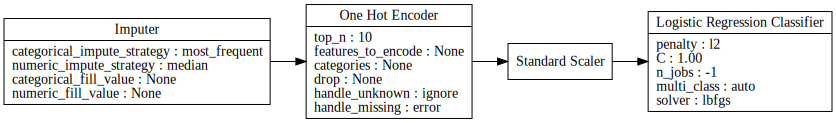

In [8]:
cp.graph()

You can see a textual representation of the pipeline by calling `.describe()`:

In [9]:
cp.describe()

*******************
* Custom Pipeline *
*******************

Problem Type: multiclass
Model Family: Linear

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : median
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. One Hot Encoder
	 * top_n : 10
	 * features_to_encode : None
	 * categories : None
	 * drop : None
	 * handle_unknown : ignore
	 * handle_missing : error
3. Standard Scaler
4. Logistic Regression Classifier
	 * penalty : l2
	 * C : 1.0
	 * n_jobs : -1
	 * multi_class : auto
	 * solver : lbfgs


## Component Graph

You can use the pipeline's `component_graph` attribute to access a component at a specific index:

In [10]:
first_component = cp.component_graph[0]
print (first_component.name)

Imputer


Alternatively, you can use `pipeline.get_component(name)` and provide the component name instead (API reference [here](../generated/methods/evalml.pipelines.PipelineBase.get_component.ipynb)):

In [11]:
cp.get_component('Imputer')

Imputer(categorical_impute_strategy='most_frequent', numeric_impute_strategy='median', categorical_fill_value=None, numeric_fill_value=None)

## Pipeline Estimator

EvalML enforces that the last component of a pipeline is an estimator. You can access this estimator directly by using either `pipeline.component_graph[-1]` or `pipeline.estimator`.

In [12]:
cp.component_graph[-1]

LogisticRegressionClassifier(penalty='l2', C=1.0, n_jobs=-1, multi_class='auto', solver='lbfgs')

In [13]:
cp.estimator

LogisticRegressionClassifier(penalty='l2', C=1.0, n_jobs=-1, multi_class='auto', solver='lbfgs')

## Input Feature Names

After a pipeline is fitted, you can access a pipeline's `input_feature_names` attribute to obtain a dictionary containing a list of feature names passed to each component of the pipeline. This could be especially useful for debugging where a feature might have been dropped or detecting unexpected behavior.

In [14]:
pipeline.input_feature_names

{'Imputer': ['alcohol',
  'malic_acid',
  'ash',
  'alcalinity_of_ash',
  'magnesium',
  'total_phenols',
  'flavanoids',
  'nonflavanoid_phenols',
  'proanthocyanins',
  'color_intensity',
  'hue',
  'od280/od315_of_diluted_wines',
  'proline'],
 'Random Forest Classifier': ['alcohol',
  'malic_acid',
  'ash',
  'alcalinity_of_ash',
  'magnesium',
  'total_phenols',
  'flavanoids',
  'nonflavanoid_phenols',
  'proanthocyanins',
  'color_intensity',
  'hue',
  'od280/od315_of_diluted_wines',
  'proline']}

## Generate Code

Once you have a pipeline defined in EvalML, you can generate string Python code to recreate this pipeline, which can then be saved and run elsewhere with EvalML. `generate_pipeline_code` requires a pipeline instance as the input. It can also handle custom components, but it won't return the code required to define the component.

In [15]:
from evalml.pipelines.utils import generate_pipeline_code
from evalml.pipelines import MulticlassClassificationPipeline
import pandas as pd

class MyDropNullColumns(Transformer):
    """Transformer to drop features whose percentage of NaN values exceeds a specified threshold"""
    name = "My Drop Null Columns Transformer"
    hyperparameter_ranges = {}

    def __init__(self, pct_null_threshold=1.0, random_state=0, **kwargs):
        """Initalizes an transformer to drop features whose percentage of NaN values exceeds a specified threshold.

        Arguments:
            pct_null_threshold(float): The percentage of NaN values in an input feature to drop.
                Must be a value between [0, 1] inclusive. If equal to 0.0, will drop columns with any null values.
                If equal to 1.0, will drop columns with all null values. Defaults to 0.95.
        """
        if pct_null_threshold < 0 or pct_null_threshold > 1:
            raise ValueError("pct_null_threshold must be a float between 0 and 1, inclusive.")
        parameters = {"pct_null_threshold": pct_null_threshold}
        parameters.update(kwargs)

        self._cols_to_drop = None
        super().__init__(parameters=parameters,
                         component_obj=None,
                         random_state=random_state)

    def fit(self, X, y=None):
        pct_null_threshold = self.parameters["pct_null_threshold"]
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        percent_null = X.isnull().mean()
        if pct_null_threshold == 0.0:
            null_cols = percent_null[percent_null > 0]
        else:
            null_cols = percent_null[percent_null >= pct_null_threshold]
        self._cols_to_drop = list(null_cols.index)
        return self

    def transform(self, X, y=None):
        """Transforms data X by dropping columns that exceed the threshold of null values.
        Arguments:
            X (pd.DataFrame): Data to transform
            y (pd.Series, optional): Targets
        Returns:
            pd.DataFrame: Transformed X
        """

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.drop(columns=self._cols_to_drop, axis=1)

class CustomPipeline(MulticlassClassificationPipeline):
    name = "Custom Pipeline"
    component_graph = ['Imputer', MyDropNullColumns, 'DateTime Featurization Component', 'One Hot Encoder', 'Random Forest Classifier']
    custom_hyperparameters={
        "Imputer": {
            "numeric_impute_strategy": ['mean', 'median']
        }
    }

pipeline_instance = CustomPipeline(parameters={"Imputer": {"numeric_impute_strategy": "median"}})
code = generate_pipeline_code(pipeline_instance)
print(code)

# This string can then be pasted into a separate window and run, although since the pipeline has custom component `MyDropNullColumns`, 
#      the code for that component must also be included

from evalml.demos import load_fraud
X, y = load_fraud()
exec(code)
pipeline.fit(X, y)

from evalml.pipelines.multiclass_classification_pipeline import MulticlassClassificationPipeline

class CustomPipeline(MulticlassClassificationPipeline):
	component_graph = [
		'Imputer',
		MyDropNullColumns,
		'DateTime Featurization Component',
		'One Hot Encoder',
		'Random Forest Classifier'
	]
	custom_hyperparameters = {'Imputer': {'numeric_impute_strategy': ['mean', 'median']}}
	name = 'Custom Pipeline'

parameters = {
	"Imputer": {
		"categorical_impute_strategy": "most_frequent",
		"numeric_impute_strategy": "median",
		"categorical_fill_value": None,
		"numeric_fill_value": None
	},
	"My Drop Null Columns Transformer": {
		"pct_None_threshold": 1.0
	},
	"DateTime Featurization Component": {
		"features_to_extract": [
			"year",
			"month",
			"day_of_week",
			"hour"
		]
	},
	"One Hot Encoder": {
		"top_n": 10,
		"features_to_encode": None,
		"categories": None,
		"drop": None,
		"handle_unknown": "ignore",
		"handle_missing": "error"
	},
	"Random Forest Classifier": {
		"n_es

CustomPipeline(parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'median', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'My Drop Null Columns Transformer':{'pct_null_threshold': 1.0, 'pct_None_threshold': 1.0}, 'DateTime Featurization Component':{'features_to_extract': ['year', 'month', 'day_of_week', 'hour']}, 'One Hot Encoder':{'top_n': 10, 'features_to_encode': None, 'categories': None, 'drop': None, 'handle_unknown': 'ignore', 'handle_missing': 'error'}, 'Random Forest Classifier':{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1},})